# Sensitivity to time step, bathymetry and background vertical mixing

Gustavo Marques (gmarques@ucar.edu)

Last update: 03/06/2020

## Forced ocean/sea-ice experiments 

* EXP#13: MEKE, 0.1667 m/day, MEKE_GEOMETRIC_ALPHA = 0.08, CDRAG_MEKE = 0.003 and AH = 1.0E+12 (extreme sfc value after ~ 84.5 years)
* EXP#19: Like #13 with min depth = 30 m in the southern ocean, updated time step  
* EXP#21: Like EXP19 with time step from EXP13 + updated sandbox (vertical mixing)
* EXP#22: Like EXP13 with updated sandbox (vertical mixing). Topog is different than in EXP19 or EXP21
* EXP#23: Like EXP19, but with updated background vertical mixing

### What should be compared:

* Time step: EXP21 vs EXP23
* Topog: EXP21 vs EXP22
* Background vertical mixing: EXP19 vs EXP23

PS1: EXP13 started ~ 3 months ago. There has been many changes in dev/ncar and MOM_interface since then. I cannot explain why it is so different than the other exps. Speculation: I recall that Willy I have hard-coded some parameters in MEKE (e.g., MEKE bottom drag coeff) when we were marking adjustments and this run might have used this branch. 

PS2: CFL violation in EXP22 (year 16). Location  ( -51.33 E  -76.63 N)

### 1.1 Globally-averaged ocean properties

In [8]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import warnings
from mom6_tools.m6plot import xycompare, xyplot
warnings.filterwarnings("ignore")
%matplotlib inline

In [9]:
path = '/glade/scratch/gmarques/'
exps = ['g.c2b6.GJRA.TL319_t061.long_JRA_mct.013', \
        'g.c2b6.GJRA.TL319_t061.long_JRA_mct.019', \
        'g.c2b6.GJRA.TL319_t061.long_JRA_mct.021', \
        'g.c2b6.GJRA.TL319_t061.long_JRA_mct.022',  \
        'g.c2b6.GJRA.TL319_t061.long_JRA_mct.023']
labels = ['EXP13', 'EXP19', 'EXP21', 'EXP22',  'EXP23']

def get_data(full_path, variables):
  def preprocess(ds):
    ''' Return the dataset with variable'''
    return ds[variables]
  ds = xr.open_mfdataset(full_path, data_vars='minimal', \
                         coords='minimal', compat='override', preprocess=preprocess)
  return ds

import seaborn, matplotlib
matplotlib.rcParams.update({'font.size': 14})

In [10]:
# load pre-difined masks
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6toolbox import genBasinMasks
from mom6_tools.m6plot import ztplot
grd = MOM6grid('/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.002/run/g.c2b6.GJRA.TL319_t061.long_JRA_mct.002.mom6.static.nc')
depth = grd.depth_ocean
# remote Nan's, otherwise genBasinMasks won't work
depth[np.isnan(depth)] = 0.0
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth, xda=True)

MOM6 grid successfully loaded... 

11.16427964664149 64.78854837178643 [391, 434]


/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.013/run/*mom6.hm_*.nc
/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.019/run/*mom6.hm_*.nc
/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.021/run/*mom6.hm_*.nc
/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.022/run/*mom6.hm_*.nc
/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.023/run/*mom6.hm_*.nc


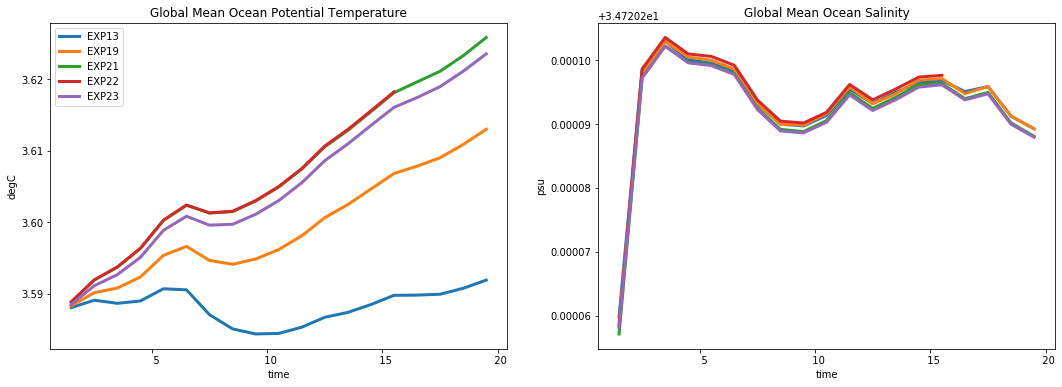

In [11]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
variables = ['thetaoga', 'soga']
for i in range(len(exps)):
  tmp = path+exps[i]+'/run/*mom6.hm_*.nc'
  print(tmp)
  ds = get_data(tmp,variables)
  ds1 = ds.sel(time=slice('0001-01-01', '0020-01-01'))
  ds1['thetaoga'].plot(ax=ax[0], label=labels[i], lw=3)
  ds1['soga'].plot(ax=ax[1], lw=3)

ax[0].set_title(ds1.thetaoga.attrs['long_name']); ax[0].set_ylabel(ds1.thetaoga.attrs['units'])
ax[1].set_title(ds1.soga.attrs['long_name']); ax[1].set_ylabel(ds1.soga.attrs['units']); ax[0].legend()
plt.show()

/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.013/run/ocean.stats.nc
/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.019/run/ocean.stats.nc
/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.021/run/ocean.stats.nc
/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.022/run/ocean.stats.nc
/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.023/run/ocean.stats.nc


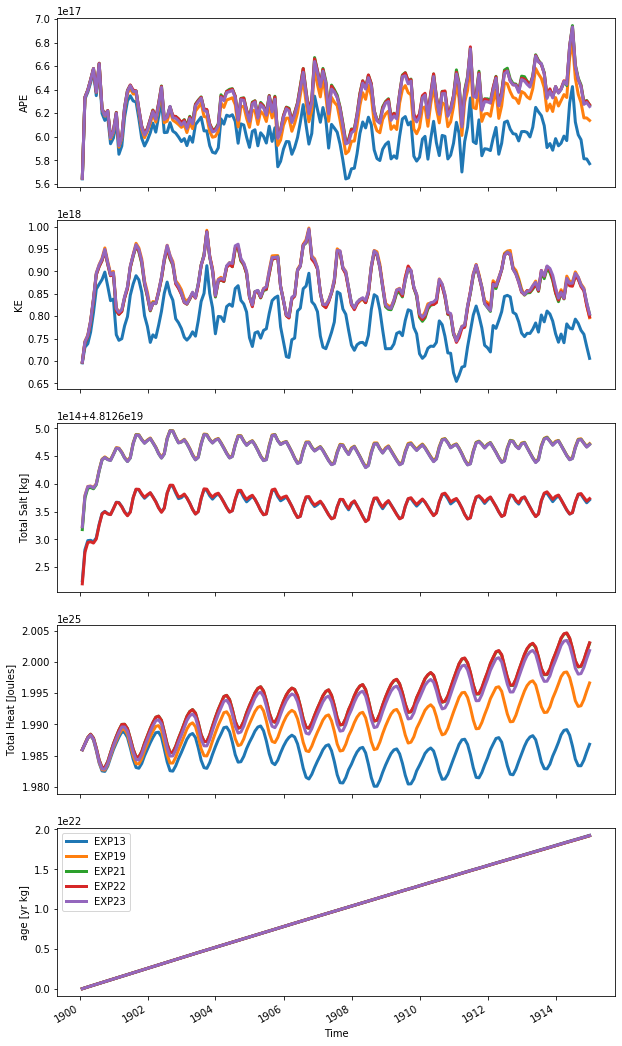

In [12]:
%matplotlib inline
variables = ['APE', 'KE', 'Salt', 'Heat', 'age']
import pandas as pd
fig, ax = plt.subplots(nrows=len(variables), ncols=1, figsize=(10,18), sharex=True)
for i in range(len(exps)): 
  path_to_file = path+exps[i]+'/run/ocean.stats.nc'
  print(path_to_file)
  ds = xr.open_dataset(path_to_file)
  time = pd.date_range('1900-01-01', periods=len(ds.Time), freq='D')
  ds['Time'] = time[:]  
  ds1 = ds.resample(Time="1M", closed='left', keep_attrs=True).mean(dim='Time', keep_attrs=True) 
  ds2 = ds1.sel(Time=slice('1900-01-01', '1915-01-01'))
  for var, j in zip(variables, range(len(variables))):
    if len(ds2[var].shape) > 1:
        tmp = ds2[var].sum(axis=1)
    else:
        tmp = ds2[var]
    tmp.plot(ax=ax[j], label=labels[i], lw=3)
    ax[j].set_xlabel('')
    
ax[j].set_xlabel('Time'); ax[j].legend()

### 1.2 SST and SSS

### EXP21 vs EXP23 (Time step)

/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.021/run/*mom6.hm_0010.nc
/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.023/run/*mom6.hm_0010.nc


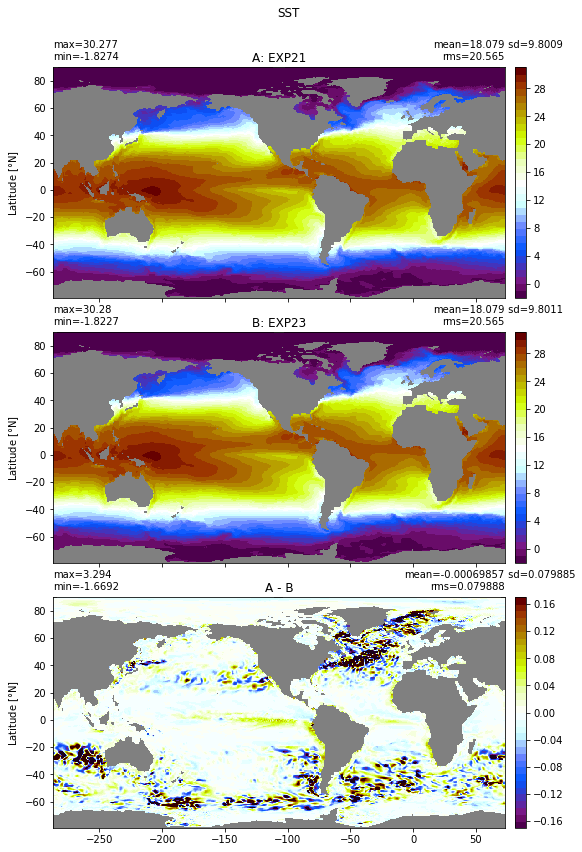

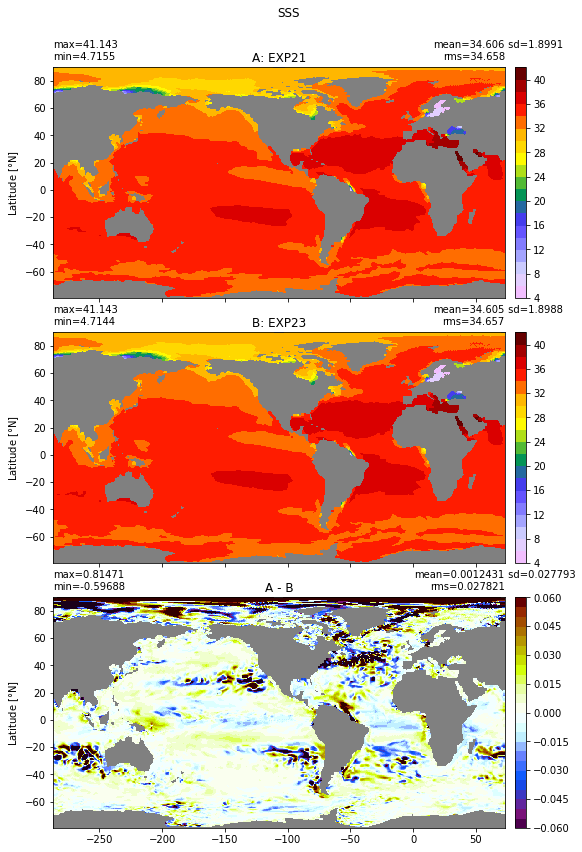

In [15]:
%matplotlib inline
variables = ['tos', 'sos']
exp21 = path+exps[2]+'/run/*mom6.hm_0010.nc'
print(exp21)
ds21 = get_data(exp21,variables)
exp23 = path+exps[4]+'/run/*mom6.hm_0010.nc'
print(exp23)
ds23 = get_data(exp23,variables)  

###### SST #############
tos21 = np.ma.masked_invalid(ds21.tos[0,:].values) 
tos23 = np.ma.masked_invalid(ds23.tos[0,:].values) 
xycompare(tos21, tos23, grd.geolon, grd.geolat, grd.area_t, title1='EXP21', title2='EXP23',suptitle='SST')

###### SSS #############
sos21 = np.ma.masked_invalid(ds21.sos[0,:].values) 
sos23 = np.ma.masked_invalid(ds23.sos[0,:].values) 
xycompare(sos21, sos23, grd.geolon, grd.geolat, grd.area_t, title1='EXP21', title2='EXP23',suptitle='SSS')  

### EXP21 vs EXP22 (topography)

/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.022/run/*mom6.hm_0010.nc


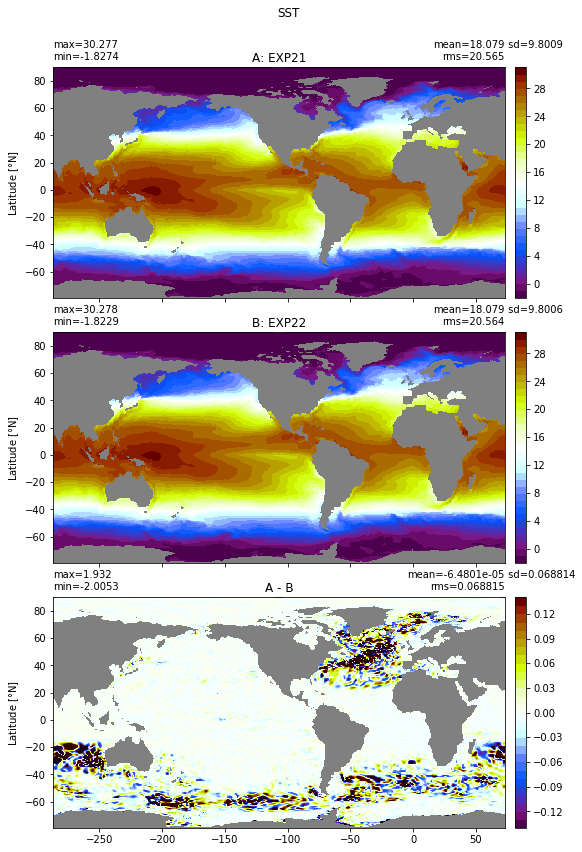

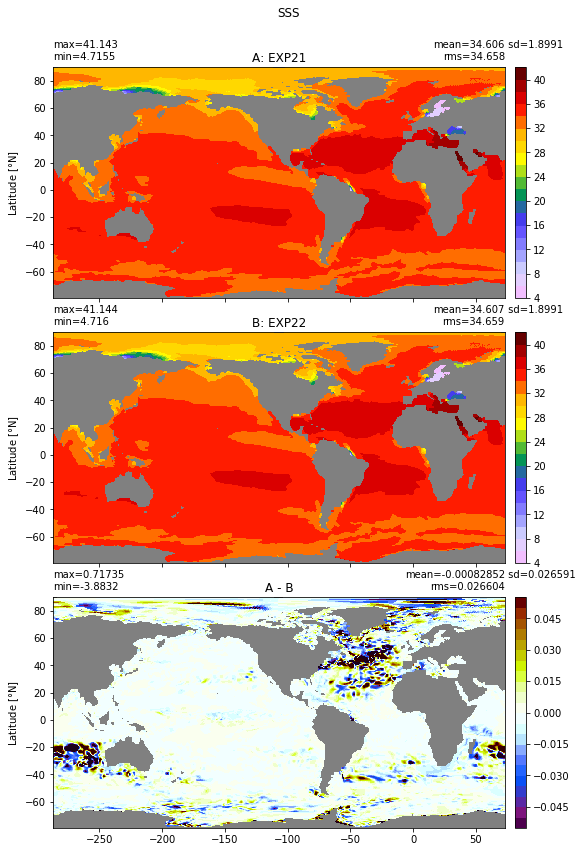

In [16]:
%matplotlib inline
variables = ['tos', 'sos']

exp22 = path+exps[3]+'/run/*mom6.hm_0010.nc'
print(exp22)
ds22 = get_data(exp22,variables)  

###### SST #############
tos22 = np.ma.masked_invalid(ds22.tos[0,:].values) 
xycompare(tos21, tos22, grd.geolon, grd.geolat, grd.area_t, title1='EXP21', title2='EXP22',suptitle='SST')

###### SSS #############
sos22 = np.ma.masked_invalid(ds22.sos[0,:].values) 
xycompare(sos21, sos22, grd.geolon, grd.geolat, grd.area_t, title1='EXP21', title2='EXP22',suptitle='SSS')  

### EXP19 vs EXP23 (background vertical mixing)

/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.019/run/*mom6.hm_0010.nc


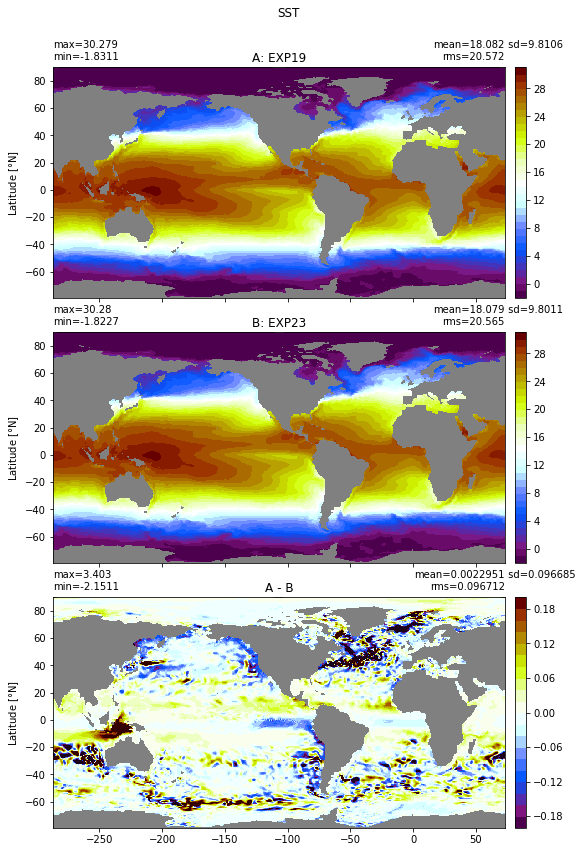

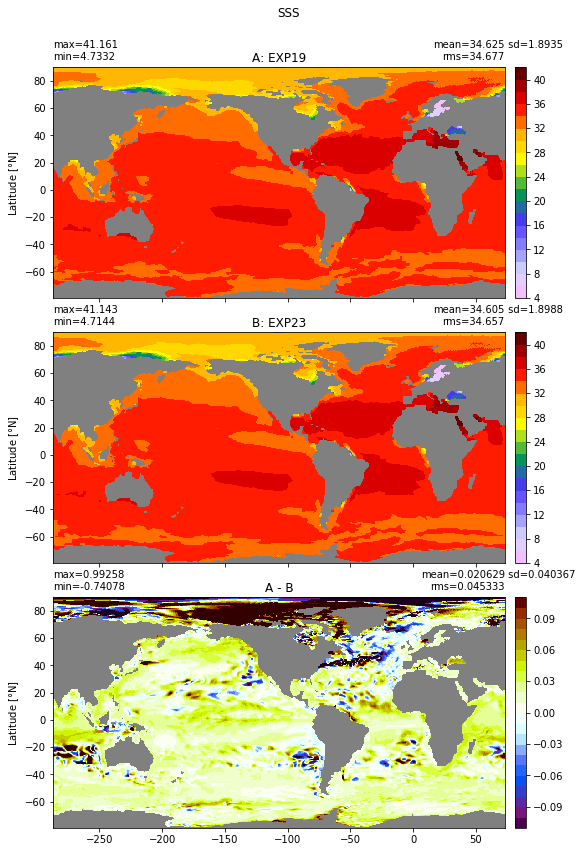

In [18]:
%matplotlib inline
variables = ['tos', 'sos']
exp19 = path+exps[1]+'/run/*mom6.hm_0010.nc'
print(exp19)
ds19 = get_data(exp19,variables) 

###### SST #############
tos19 = np.ma.masked_invalid(ds19.tos[0,:].values) 
xycompare(tos19, tos23, grd.geolon, grd.geolat, grd.area_t, title1='EXP19', title2='EXP23',suptitle='SST')

###### SSS #############
sos19 = np.ma.masked_invalid(ds19.sos[0,:].values) 
xycompare(sos19, sos23, grd.geolon, grd.geolat, grd.area_t, title1='EXP19', title2='EXP23',suptitle='SSS')  